# Sassie Ridge "Model" Results 
### Notebook contents 
* Opening all the GIS Model result files (tifs)
* Cleaning up the rasters
* Creating a mask to prevent edge effects on distance to canopy edge
* Save cleaned data to a netcdf file for use later 

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

## Working with raw NCALM Data for tidy plots

In [2]:
pwd

'/home/lumbraca/raster/python'

In [3]:
# Results from model simulations, reproject match everything to this raster
## Paths to the linux box  
tif_snowdepth = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_snowdepth.tif", masked=True)

# should be able to import the entire domain for FL, then when I reproject_match, it clips to the extent of the snow depth 
# raw datasets 
tif_dtm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dtm_snowoff.tif", masked=True)
tif_dsm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dsm_snowoff.tif", masked=True)
tif_dtm_snowon = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dtm_snowon.tif", masked=True)
tif_dsm_snowon = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dsm_snowon.tif", masked=True)

# simple calculations
tif_aspect = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_aspect.tif", masked=True)
tif_slope = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_slope.tif", masked=True)

tif_chm_snowoff = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_chm_snowoff.tif", masked=True)
tif_chmws = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_chmws.tif", masked=True)
tif_chmas = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_chmas.tif", masked=True)

tif_dce = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dce.tif", masked=True)
tif_dah = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_dah.tif", masked=True)
tif_tpi = rioxarray.open_rasterio("/storage/lumbraca/NCALM_sites/sr/sr_tpi.tif", masked=True)

# Put it all together 
ds = xr.Dataset({"snowdepth":tif_snowdepth,
                 "dtm_snowoff":tif_dtm_snowoff.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_snowoff":tif_dsm_snowoff.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dtm_snowon":tif_dtm_snowon.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dsm_snowon":tif_dsm_snowon.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "aspect":tif_aspect.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "slope":tif_slope.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "chm_snowoff":tif_chm_snowoff.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "chmws":tif_chmws.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "chmas":tif_chmas.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dce":tif_dce.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "tpi":tif_tpi.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear),
                 "dah":tif_dah.rio.reproject_match(tif_snowdepth, resampling = rasterio.enums.Resampling.bilinear)})

In [4]:
# close all the datasets to save memory 
tif_dtm_snowoff.close()
tif_dsm_snowoff.close()
tif_dtm_snowon.close()
tif_dsm_snowon.close()

tif_aspect.close()
tif_slope.close()
tif_chm_snowoff.close()
tif_chmws.close()
tif_chmas.close()

tif_dce.close()
tif_dah.close()
tif_tpi.close()

tif_snowdepth.close()

In [5]:
ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 5785, y: 7790)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.494e+06 1.494e+06 ... 1.511e+06 1.511e+06
  * y            (y) float64 7.567e+05 7.567e+05 ... 7.333e+05 7.333e+05
    spatial_ref  int64 0
Data variables: (12/13)
    snowdepth    (band, y, x) float32 ...
    dtm_snowoff  (band, y, x) float32 2.662e+03 2.663e+03 ... 5.025e+03
    dsm_snowoff  (band, y, x) float32 2.744e+03 2.742e+03 ... 5.075e+03
    dtm_snowon   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    dsm_snowon   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    aspect       (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    chm_snowoff  (band, y, x) float32 25.37 24.33 26.75 ... 22.29 19.77 14.7
    chmws        (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    chmas        (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    dce          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tpi          (band, y, x) float32 -1.782 -0.96 -0.3022 ... -8.634 -7.879
    dah          (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [6]:
# Because this takes so long to create, let's save all the raw files into a netcdf, before cleaning up the dataset and resaving 
ds.to_netcdf('/home/lumbraca/raster/data/sr_model_rawdata_create_netcdf.nc')

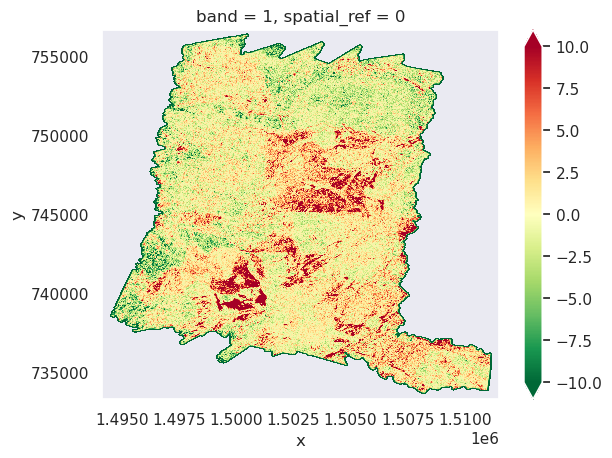

In [7]:
ds.dce.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # just want to make sure the correct dce is uploaded 

good, now we are ready to move forward with the dataset. 
## Clean up the datasets 

In [10]:
# make all values of the dataset nan where the values of snow depth are nan 
ds = ds.where(ds.snowdepth > -100) # make all values of all rasters nan where the values of one raster are nan 

In [11]:
# The raw FL lidar datasets are in feet (it's the origional dataset) 
ds['dtm_snowoff'] = ds['dtm_snowoff']*0.3048 #snow off dtm to meters
ds['dsm_snowoff'] = ds['dtm_snowoff']*0.3048 #snow off dsm to meters
ds['dtm_snowon']  = ds['dtm_snowon']*0.3048  #snow on dtm to meters
ds['dsm_snowon']  = ds['dtm_snowon']*0.3048  #snow on dsm to meters

ds['dem'] = ds['dtm_snowoff'].copy(deep=True) #save dem as a variable 

# The Simple Rasters 
ds['snowdepth'] = ds['snowdepth'].where(ds['snowdepth'] >= 0, drop=True) # only keeping snow depth >= 0 for now... coming back to this 
ds['snowdepth'] = ds['snowdepth'].where(ds['snowdepth'] < 20, drop=True) # only keeping snow depth < 20 for now... coming back to this

ds['slope'] = ds['slope'].where(ds['slope'] >= 0, drop=True) # keep slope above 0
ds['aspect'] = ds['aspect'].where(ds['aspect'] >= -1, drop=True) # keep aspect above -1 

ds['tpi'] = ds['tpi'].where(~(ds['tpi'] >  100), drop=True) # removing strange tpi values 
ds['tpi'] = ds['tpi'].where(~(ds['tpi'] < -100), drop=True) # removing strange tpi values 

ds['dah'] = ds['dah'].where(~(ds['dah'] > 50), drop=True) # droping any gaps that are bigger than 50
ds['dah'] = ds['dah'].where(~(ds['dah'] < -50), drop=True) # droping any gaps that are smaller than -50

## Canopy things... more complicated 
# for dce, we want to make sure there are not weird edge effects. The reproject match should take care of this a bit.. 
ds['dce'] = ds['dce'].where(~(ds['dce'] > 50), drop=True)  # droping any gaps that are bigger than 50, already cut it to 30 
ds['dce'] = ds['dce'].where(~(ds['dce'] < -50), drop=True) # droping any gaps that are smaller than -50

ds['chm_snowoff'] = ds['chm_snowoff'].where(ds['chm_snowoff'] >= 0, drop=True) # keep canopy height model above 0 
ds['chmws'] = ds['chmws'].where(ds['chmws'] >= 0, drop=True) 
ds['chmas'] = ds['chmas'].where(ds['chmas'] >= 0, drop=True) 

In [12]:
print("Mean:",  ds.snowdepth.mean())
print("Median:",  ds.snowdepth.median())
print("STD:",  ds.snowdepth.std())

Mean: <xarray.DataArray 'snowdepth' ()>
array(2.3779392, dtype=float32)
Coordinates:
    spatial_ref  int64 0
Median: <xarray.DataArray 'snowdepth' ()>
array(2.3794641, dtype=float32)
Coordinates:
    spatial_ref  int64 0
STD: <xarray.DataArray 'snowdepth' ()>
array(0.88642716, dtype=float32)
Coordinates:
    spatial_ref  int64 0


## Remove outlier snow depth values 
### Snow depth for Sassie Ridge  
* mean: 2.38 (ds.snowdepth.mean())
* median: 2.38 (ds.snowdepth.median ())
* std: 0.88 (ds.snowdepth.std())

So, if we want to remove snow depth values that are > 3 SD from the mean... 

We are going to to bound snow depth by +- (0.88)*3 of 2.38
- i.e., bounding snow depth by 0 and 5.02 (we can say 5 or 6?) we say 6 for now

In [13]:
ds['snowdepth_raw'] = ds['snowdepth'].copy(deep=True)
ds['snowdepth'] = ds['snowdepth'].where(ds['snowdepth'] < 6) # should change this depending on the site

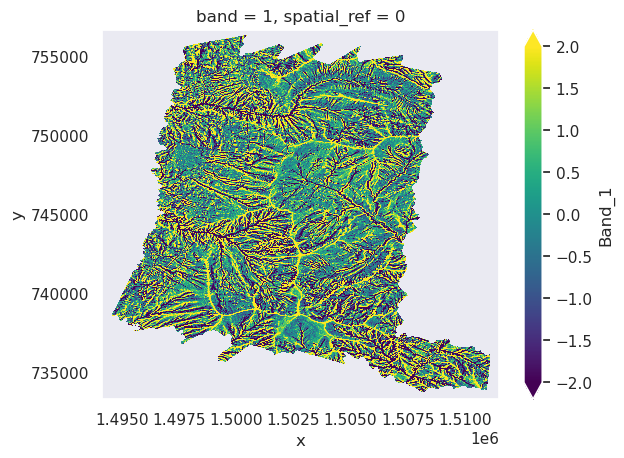

In [14]:
ds.tpi.plot(vmin=-2, vmax=2)

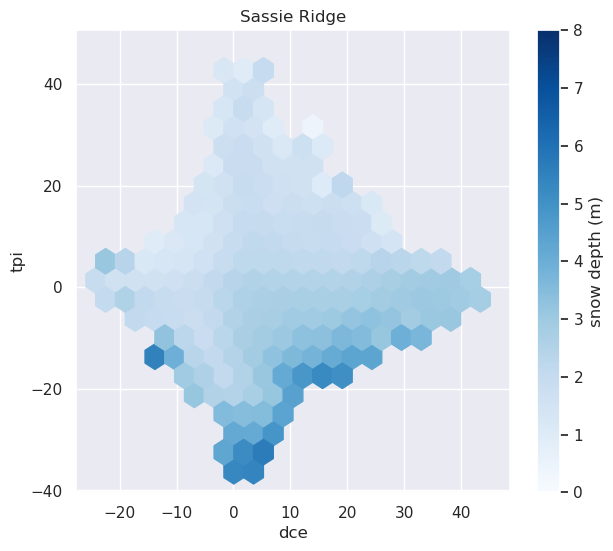

In [18]:
# need to check TPI to see if there is a negative issues going on
plt.figure(figsize=(7,6))

plt.hexbin(ds.dce.values.flatten(), ds.tpi.values.flatten(), C=ds.snowdepth.values.flatten(), cmap='Blues', vmin=0, vmax=8,
          gridsize=20, mincnt=2)

cb = plt.colorbar()
cb.set_label('snow depth (m)')

plt.xlabel('dce')
plt.ylabel('tpi')
# plt.xlim([-20,20])
# plt.ylim([-1,1])

plt.title('Sassie Ridge')
plt.show()

## Create a buffer on DCE to remove edge effects 

In [15]:
# first creating a binary mask
# if there are values then 1, if not then 0 
dce_mask = ds.dce.copy(deep=True) # first copy dce 
dce_mask = dce_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
dce_mask = dce_mask.where(dce_mask < -50, 1) # where condition is FALSE, fill with 1 
dce_mask = dce_mask.where(dce_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(dce_mask, structure=np.ones((1,50,50))).astype(dce_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# add the fixed mask to the dataset 
ds['mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['dce_raw'] = ds['dce'].copy(deep=True) # saving dce into a variable for the dataset 
ds['dce'] = ds['dce'].where(ds['mask'] >= 1) # resaving the mask dce into dce variable 

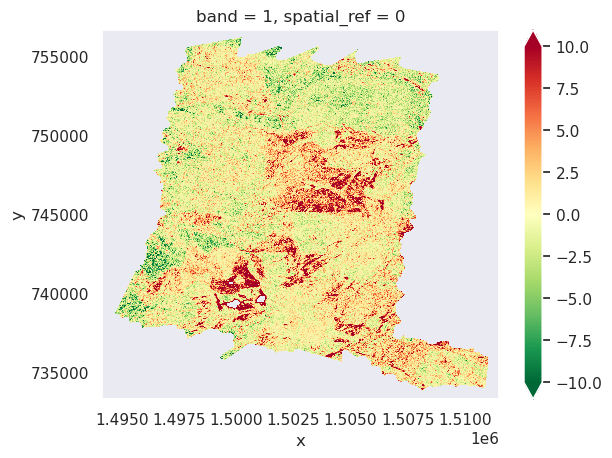

In [16]:
ds.dce.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # check the buffer worked

### Set up the different dce classifications 

In [17]:
# fix up dah classification for zero to be with negative values
dah_reclass = ds.dah.copy(deep=True)

dah_reclass = dah_reclass.where(dah_reclass <= 0, 1) # xarray.where cond = False, replace with value
dah_reclass = dah_reclass.where(dah_reclass > 0, -1)

# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds.dce.copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 30), drop=True)                    # droping any gaps that are bigger than 30
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  30)), 500)# group 1: Large Gaps      3 <  DCE <=  30
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dah_reclass'] = dah_reclass.copy(deep=True)
ds['dce_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['largeclusters'] = ds.dce_reclass.where(ds.dce_reclass == 100)
ds['smallclusters'] = ds.dce_reclass.where(ds.dce_reclass == 200)
ds['canopyedges']   = ds.dce_reclass.where(ds.dce_reclass == 300)
ds['smallgaps']     = ds.dce_reclass.where(ds.dce_reclass == 400)
ds['largegaps']     = ds.dce_reclass.where(ds.dce_reclass == 500)

## Write to nedcdf 

In [19]:
ds.to_netcdf('/home/lumbraca/raster/data/sr_model_cleandata_create_netcdf.nc')

In [20]:
ds.close()